# Position & Heading Variance Estimation
This notebook estimates the variance of the SITL simulation mock GPS position and heading estimates against ground truth.

## Imports, paths & other configuration

ULog flight logs are assumed to be found under `../output`.

In [6]:
%pylab inline
import os
import px4tools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Suppress pandas FutureWarning
from px4tools import pandas

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['lines.linewidth'] = 3

print(f'PX4Tools version: {px4tools.__version__}')  # Release 0.9.6 still has issue #40, need >0.9.6
print(f'pandas version: {pandas.__version__}')

ulog_path = '../output'
ulog_absolute_path = os.path.abspath(os.path.join(os.getcwd(), ulog_path))

print(f'ULog file path is set to {ulog_absolute_path}')

Populating the interactive namespace from numpy and matplotlib
PX4Tools version: 0.9.6+1.gff33b26
pandas version: 1.3.1
ULog file path is set to /home/hmakelin/workspace/px4_ros_com_ros2/src/gisnav/test/sitl/output


## Read ULog files

In [65]:
logs = []

for file in os.listdir(ulog_path):
    if file.endswith(".ulog"):
        logs.append(file)

print(f'Found following log files:\n{logs}')

import dateutil.parser as dparser
from functools import partial

parse_date = partial(dparser.parse, fuzzy=True)
dates = map(parse_date, logs)

import operator
index, value = max(enumerate(dates), key=operator.itemgetter(1))
        
print(f'Analyzing log with latest timestamp: {value}')

d = px4tools.read_ulog(os.path.join(ulog_path, logs[index]))

Found following log files:
['gisnav-sitl-test-log_2022-09-04T10-31-20Z.ulog']
Analyzing log with latest timestamp: 2022-09-04 10:00:00-20:00


## Boilerplate analysis

Run quick statistics and a basic visualization on the flight log.


        ESTIMATOR ANALYSIS
        -----------------------------------

        attitude error:
        	roll  mean:  -0.012848	std:	  0.533759	deg
        	pitch mean:   0.039397	std:	  0.348186	deg
        	yaw   mean:  -0.102802	std:	  0.559070	deg

        position error:
        	x mean:  -0.465808	std:	  0.955115	m
        	y mean:   0.197470	std:	  0.945970	m
        	z mean:  -2.961340	std:	  5.385241	m

        velocity error:
        	x mean:   0.041852	std:	  0.140313	m/s
        	y mean:  -0.011267	std:	  0.188965	m/s
        	z mean:  -0.045930	std:	  0.323266	m/s
        


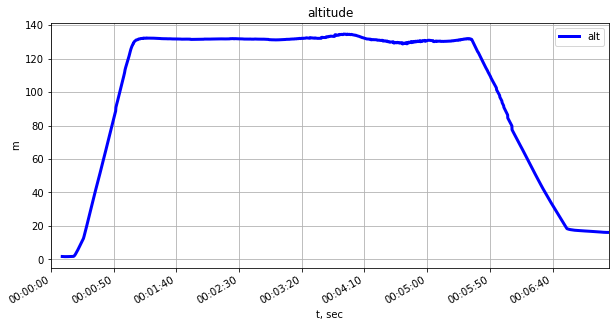

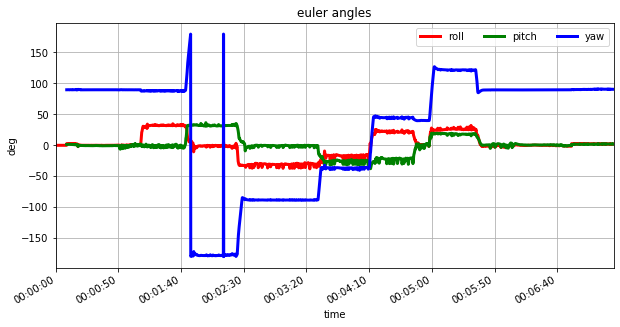

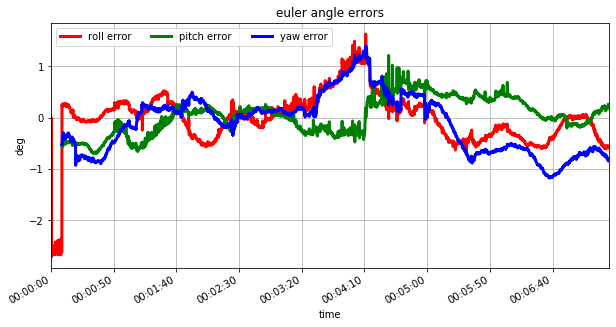

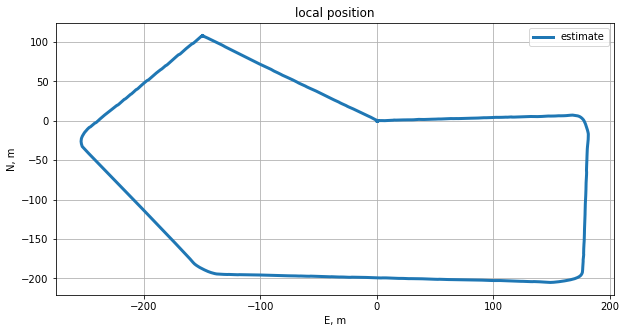

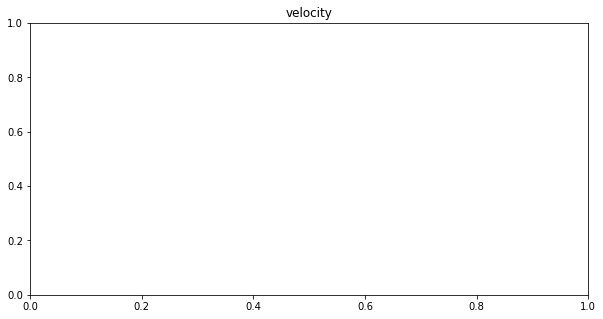

In [39]:
dt_ = 0.1
d_concat = d.concat(dt=dt_)
d_concat_computed = px4tools.compute_data(d_concat)
try:
    px4tools.estimator_analysis(d_concat_computed)
except AttributeError as ae:
    print(f'Warning: AttributeError: {ae}')

## Get estimate and ground truth position

In [44]:
df = d_concat_computed

# Get mock GPS messages only (mixed in with 'real' GPS): satellites_used value should be 255
satellites_used = df['t_vehicle_gps_position_0__f_satellites_used']
mock_gps_indices = [i for i in range(len(satellites_used)) if satellites_used[i] == 255]

df = df.iloc[mock_gps_indices]

# Compare mock GPS lat, lon, alt to ground truth
lat, lon, alt = df['t_vehicle_gps_position_0__f_lat'], \
                df['t_vehicle_gps_position_0__f_lon'], \
                df['t_vehicle_gps_position_0__f_alt']
truth_lat, truth_lon, truth_alt = df['t_vehicle_global_position_groundtruth_0__f_lat'], \
                                  df['t_vehicle_global_position_groundtruth_0__f_lon'], \
                                  df['t_vehicle_global_position_groundtruth_0__f_alt']

# See px4_msgs.msg.VehicleGpsPosition or px4_msgs.msg.SensorGps definitions for scaling
alt = alt/1e3  # Convert to meters
lat = lat/1e7  # to EPSG:4326 degrees
lon = lon/1e7  # to EPSG:4326 degrees

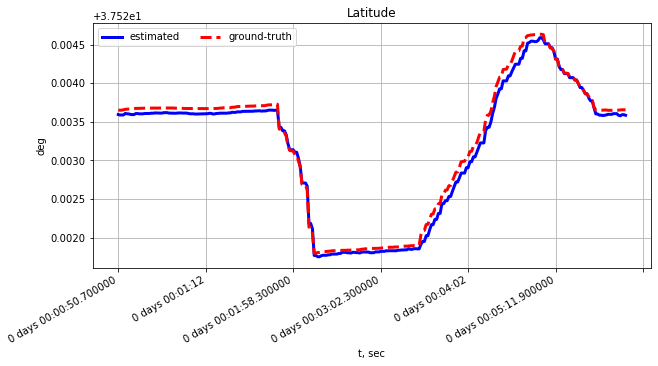

In [48]:
# Latitude plot
plt.title('Latitude')
lat.plot(label='estimated', style='b-')
truth_lat.plot(label='ground-truth', style='r--')
plt.grid()
plt.legend(loc='best', ncol=3)
plt.xlabel('t, sec')
plt.ylabel('deg')
plt.gcf().autofmt_xdate()

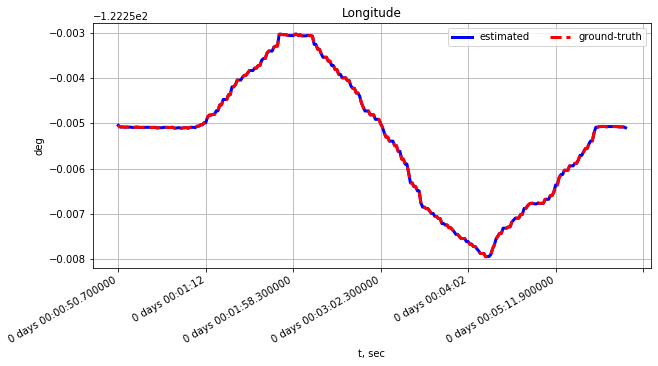

In [49]:
# Longitude plot
plt.title('Longitude')
lon.plot(label='estimated', style='b-')
lon.plot(label='ground-truth', style='r--')
plt.grid()
plt.legend(loc='best', ncol=3)
plt.xlabel('t, sec')
plt.ylabel('deg')
plt.gcf().autofmt_xdate()

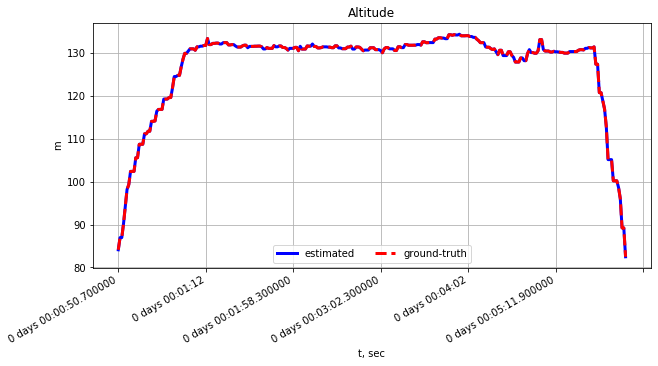

In [50]:
# Altitude plot (estimate does not account for ground elevation!)
plt.title('Altitude')
alt.plot(label='estimated', style='b-')
alt.plot(label='ground-truth', style='r--')
plt.grid()
plt.legend(loc='best', ncol=3)
plt.xlabel('t, sec')
plt.ylabel('m')
plt.gcf().autofmt_xdate()

## Error distributions

Here we will plot the position error estimates.

count    291.000000
mean      -0.000065
std        0.000050
min       -0.000174
25%       -0.000075
50%       -0.000065
75%       -0.000043
max        0.000055
dtype: float64
Horizontal position error in y axis (ENU) standard deviation (epy) in meters: 5.52


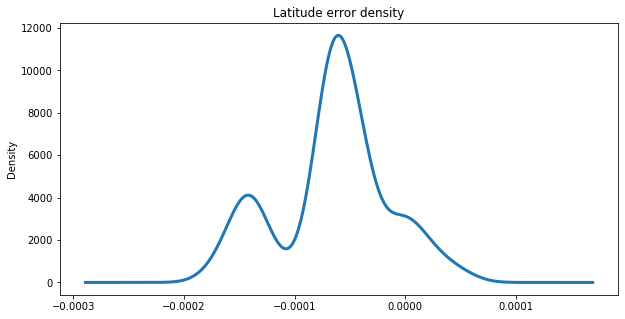

In [81]:
lat_error = lat - truth_lat
plt.title('Latitude error density')
lat_error.plot.kde()
stats = lat_error.describe()
print(stats)

# 1 deg of lat = 111 km
epy = lat_error.std() * 111000
print(f'Horizontal position error in y axis (ENU) standard deviation (epy) in meters: {round(epy, 2)}')

count    291.000000
mean       0.000039
std        0.000083
min       -0.000103
25%       -0.000033
50%        0.000028
75%        0.000123
max        0.000190
dtype: float64
Horizontal position error in x axis (ENU) standard deviation (epx) in meters: 9.11


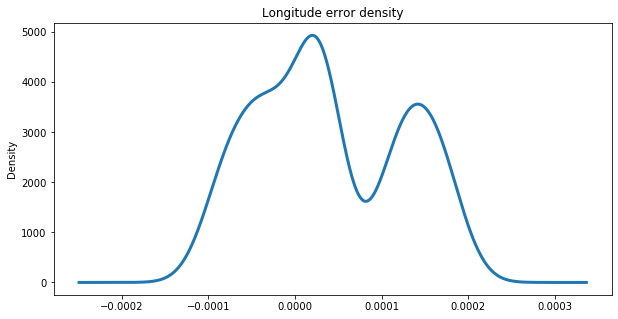

In [80]:
lon_error = lon - truth_lon
plt.title('Longitude error density')
lon_error.plot.kde()
stats = lon_error.describe()
print(stats)

# 1 deg of lat at equator = 111 km
# at x degrees lat = 111 km * cos(x) assuming simple spherical model
epx = lon_error.std() * 111000 * cos(lat.mean())
print(f'Horizontal position error in x axis (ENU) standard deviation (epx) in meters: {round(epx, 2)}')

count    291.000000
mean      -0.352038
std        1.174729
min       -3.462999
25%       -0.653003
50%       -0.328000
75%       -0.096003
max        3.842001
dtype: float64
Vertical position error standard deviation (epv) in meters: 1.17


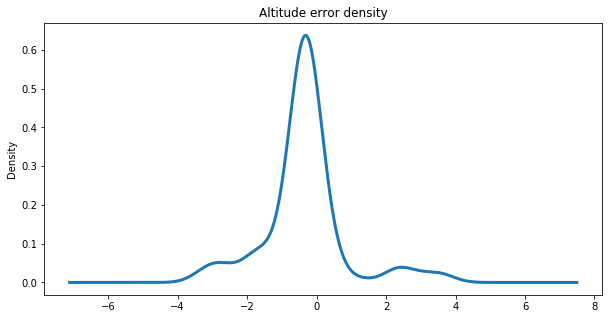

In [79]:
alt_error = alt - truth_alt
plt.title('Altitude error density')
alt_error.plot.kde()
stats = alt_error.describe()
print(stats)

print(f'Vertical position error standard deviation (epv) in meters: {round(alt_error.std(), 2)}')

## Estimate lag between estimate and ground truth

Best delay estimate is the time offset or lag at which time series cross-correlation is highest.

Time offset with max cross-correlation index: -1 (time steps)
Time offset with max cross-correlation in seconds: -0.1 sec
Mock GPS timestamps are -0.1 seconds too low (too early) compared to ground truth.


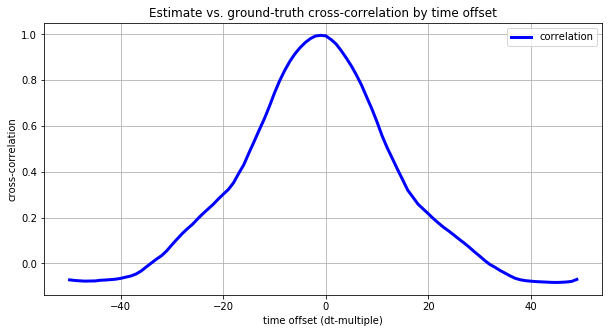

In [66]:
corr = []

# Pick a range so that when it is multiplied by dt it is at least several seconds wide
# Choosing a wide range is to ensure we find the global maximum of the cross-correlation curve
xrange = range(-50, 50)
for lag in xrange:
    corr.append(truth_alt.corr(alt.shift(lag)))
    
corr = pandas.Series(corr)
corr.index = xrange

plt.title('Estimate vs. ground-truth cross-correlation by time offset')
corr.plot(label='correlation', style='b-')
plt.grid()
plt.legend(loc='best', ncol=3)
plt.xlabel('time offset (dt-multiple)')
plt.ylabel('cross-correlation')

max_index = corr.idxmax()
delay = dt_*max_index

print(f'Time offset with max cross-correlation index: {max_index} (time steps)')
print(f'Time offset with max cross-correlation in seconds: {delay} sec')  # dt_ was defined earlier when the basic analysis was done

if max_index == 0:
    print('Mock GPS timestamps seem well synchronized with ground truth.')
elif max_index > 0:
    print(f'Mock GPS timestamps are {delay} seconds too high (too late) compared to ground truth.')
elif max_index < 0:
    print(f'Mock GPS timestamps are {delay} seconds too low (too early) compared to ground truth.')